# Tree SHAP For Carnivores

In [1]:
#!pip install hyperopt
#!pip install lightgbm

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

ImportError: cannot import name 'ensure_object'

## Read Data

In [4]:
data = pd.read_csv("terrarium1.csv")

### Dimensions of Data

In [5]:
data.shape

(61596, 17)

### Peak at the Data

In [6]:
data.head()

,identifier,creatureType,Time,CanReproduce,CanGrow,CanAttack,Energy,MaxEnergy,Size,Age,Activity,herbivores,carnivores,plants,herbivores_e,carnivores_e,plants_e
0,0,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
1,1,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
2,2,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
3,3,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
4,4,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2


## Selecting Carnivores
We will select only herbivores for our analysis.

In [7]:
new_data = data[data['creatureType']== 1]

### Some Pre Processing
If we have any duplicate records then we will remove them and keep first.

In [8]:
new_data.duplicated().sum()

0

In [9]:
new_data.drop_duplicates(keep='first', inplace=True)

#### Check Null Values

In [10]:
data.isnull().sum()

identifier      0
creatureType    0
Time            0
CanReproduce    0
CanGrow         0
CanAttack       0
Energy          0
MaxEnergy       0
Size            0
Age             0
Activity        0
herbivores      0
carnivores      0
plants          0
herbivores_e    0
carnivores_e    0
plants_e        0
dtype: int64

### Train Test Split
We will remove some attributes that are effecting our output and not gives any information. I choose these attributes after removing attributes one by one and checking model performance.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(new_data.drop(['Activity','MaxEnergy',"creatureType","identifier","Time"],axis=1),new_data['Activity'],train_size=0.30,random_state=10,stratify=new_data['Activity'])

In [13]:
X_train.head()

,CanReproduce,CanGrow,CanAttack,Energy,Size,Age,herbivores,carnivores,plants,herbivores_e,carnivores_e,plants_e
49181,0,0,0,0.800067,1.00000,2.009037,7,2,0,7,2,0.00000
25781,0,0,0,3.522944,2.31954,3.352939,8,2,18,8,2,77.74106
17365,0,0,0,0.757260,1.00000,2.437006,7,2,18,7,2,74.86101
19031,0,0,0,0.738757,1.00000,2.621992,7,2,18,7,2,60.16094
52421,0,0,0,0.746058,1.00000,2.548998,7,2,0,7,2,0.00000


### Class Distribution
Let's check which classes we have and what is the distribution of classes.

In [14]:
y_class = pd.DataFrame(y_train).reset_index()

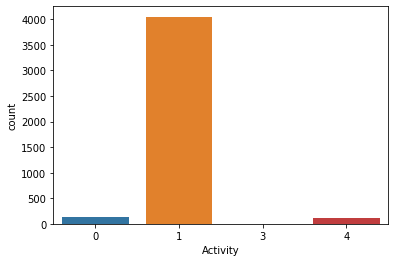

In [15]:
sns.countplot(x= "Activity",data= y_class)

For carnivores, we have only examples of 0,1, and 4. And also 0 and 4 are in minority. We will train model but let's check how well it will perform.

## Baseline LGB Model

In [16]:
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature='auto')
dtest = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')

In [18]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_cat_to_onehot': 4,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 100,
    'num_class':5 
    
}

In [19]:
gbm = lgb.train(params,
                dtrain,
                num_boost_round=100,
                verbose_eval=100,
                valid_sets=[dtest, dtrain],  # eval training data
                )

[100]	training's multi_logloss: 0.0156163	valid_0's multi_logloss: 0.0223134


### Important Varibales base on Models

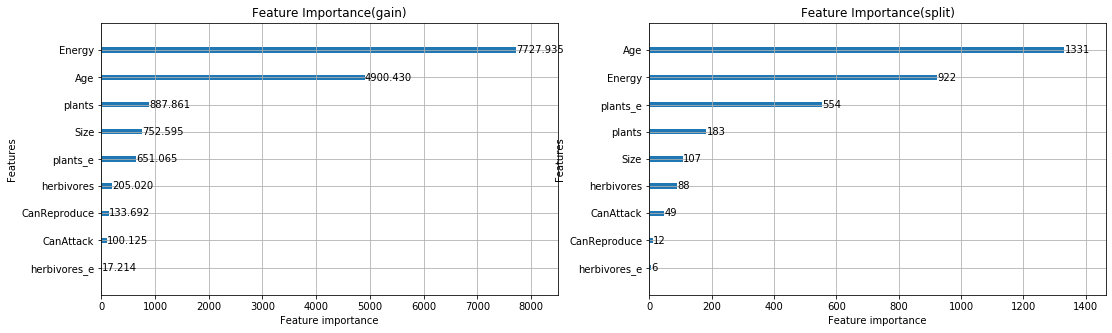

In [20]:
f, axs = plt.subplots(1, 2, figsize=(18, 5))
lgb.plot_importance(gbm, importance_type='gain', title='Feature Importance(gain)', ax=axs[0]);
lgb.plot_importance(gbm, importance_type='split', title='Feature Importance(split)', ax=axs[1]);

In [21]:
space4lgb = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.5),
    'num_leaves': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('num_leaves', 4.5, 1, 1), 2)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'feature_fraction_bynode': hp.uniform('feature_fraction_bynode', 0.5, 1),
    'min_data_in_leaf': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('min_data_in_leaf', 4.5, 1, 1), 3)),
    'max_cat_to_onehot': pyll.scope.int(hp.quniform('max_cat_to_onehot', 4, 10, 1)),
    'lambda_l1': hp.lognormal('lambda_l1', 3, 2),
    'lambda_l2': hp.lognormal('lambda_l2', 3, 2),
    'max_bin': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('max_bin', 6.5, 1, 1), 10)), 
}
pyll.stochastic.sample(space4lgb)

{'bagging_fraction': 0.7613150972942218,
 'feature_fraction': 0.9431885603550673,
 'feature_fraction_bynode': 0.7735504300869298,
 'lambda_l1': 31.115800366176842,
 'lambda_l2': 9.481955371319922,
 'learning_rate': 0.0824814656893809,
 'max_bin': 2624,
 'max_cat_to_onehot': 6,
 'min_data_in_leaf': 72,
 'num_leaves': 45}

In [22]:
best = {
    'bagging_fraction': 0.9503770158879287,
    'feature_fraction': 0.5857131468206892,
    'feature_fraction_bynode': 0.9120554269421401,
    'lambda_l1': 1.4689729868481995,
    'lambda_l2': 0.15467766956237552,
    'learning_rate': 0.10877675624568696,
    'max_bin': 75.0,
    'max_cat_to_onehot': 6.0,
    'min_data_in_leaf': 43.0,
    'num_leaves': 9.0}
space_eval(space4lgb, best)

{'bagging_fraction': 0.9503770158879287,
 'feature_fraction': 0.5857131468206892,
 'feature_fraction_bynode': 0.9120554269421401,
 'lambda_l1': 1.4689729868481995,
 'lambda_l2': 0.15467766956237552,
 'learning_rate': 0.10877675624568696,
 'max_bin': 75,
 'max_cat_to_onehot': 6,
 'min_data_in_leaf': 43,
 'num_leaves': 9}

In [23]:
default_params = {'boosting_type': 'gbdt',
                  'objective': 'multiclass',
                  'num_boost_round': 100,
                  'metric': 'multi_logloss',
                  'categorical_feature': 'auto',
                  'valid_sets': None,
                  'bagging_seed': 100,
                  'verbose': 0,
                  'seed': 100,
                  'num_class':5
                  
                  }
params = {**default_params, **space_eval(space4lgb, best)}
del params['valid_sets'], params['num_boost_round']
params

{'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'categorical_feature': 'auto',
 'bagging_seed': 100,
 'verbose': 0,
 'seed': 100,
 'num_class': 5,
 'bagging_fraction': 0.9503770158879287,
 'feature_fraction': 0.5857131468206892,
 'feature_fraction_bynode': 0.9120554269421401,
 'lambda_l1': 1.4689729868481995,
 'lambda_l2': 0.15467766956237552,
 'learning_rate': 0.10877675624568696,
 'max_bin': 75,
 'max_cat_to_onehot': 6,
 'min_data_in_leaf': 43,
 'num_leaves': 9}

In [24]:
## Retraining the lgb model with best parameters:
gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                verbose_eval=10,
                valid_names=['eval', 'train'],
                valid_sets=[dtest, dtrain],  # eval training data
                early_stopping_rounds = 50
                )

Training until validation scores don't improve for 50 rounds
[10]	train's multi_logloss: 0.0808526	eval's multi_logloss: 0.0856089
[20]	train's multi_logloss: 0.0502203	eval's multi_logloss: 0.0554323
[30]	train's multi_logloss: 0.0373082	eval's multi_logloss: 0.0428003
[40]	train's multi_logloss: 0.0288295	eval's multi_logloss: 0.0346581
[50]	train's multi_logloss: 0.0233207	eval's multi_logloss: 0.0298173
[60]	train's multi_logloss: 0.0201729	eval's multi_logloss: 0.0271957
[70]	train's multi_logloss: 0.0183677	eval's multi_logloss: 0.0256815
[80]	train's multi_logloss: 0.0168028	eval's multi_logloss: 0.0243938
[90]	train's multi_logloss: 0.0154456	eval's multi_logloss: 0.023231
[100]	train's multi_logloss: 0.0147462	eval's multi_logloss: 0.0226408
[110]	train's multi_logloss: 0.0142642	eval's multi_logloss: 0.0222393
[120]	train's multi_logloss: 0.0137226	eval's multi_logloss: 0.0218347
[130]	train's multi_logloss: 0.01346	eval's multi_logloss: 0.0216416
[140]	train's multi_logloss:

In [25]:
y_pred = gbm.predict(X_test)

## Computing SHAP Values

In [26]:
explainer = shap.TreeExplainer(model=gbm,
                               data=None,
                               model_output='raw',
                               feature_perturbation='tree_path_dependent')

In [27]:
shap_values = explainer.shap_values(X_test)

## Correlation Function
This function we will use for plotting Correlation between given class and Variables. Positive relation Variables show as Green and Negatively correlation shows in Red and no relation with Blue.

In [34]:
def ABS_SHAP(df_shap,df):

    #import matplotlib as plt

    # Make a copy of the input data

    shap_v = pd.DataFrame(df_shap)

    feature_list = df.columns

    shap_v.columns = feature_list

    df_v = df.copy().reset_index().drop('index',axis=1)

    

    # Determine the correlation in order to plot with different colors

    corr_list = list()

    for i in feature_list:

        b = np.corrcoef(shap_v[i],df_v[i])[1][0]

        corr_list.append(b)

    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)

    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient

    corr_df.columns  = ['Variable','Corr']
    
    
    corr_df['Sign'] = np.where(corr_df['Corr']> 0,'Green','blue')
    corr_df['Sign'][corr_df['Corr'] <-0.3] = 'red'
    

    # Plot it

    shap_abs = np.abs(shap_v)

    k=pd.DataFrame(shap_abs.mean()).reset_index()

    k.columns = ['Variable','SHAP_abs']

    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')

    k2 = k2.sort_values(by='SHAP_abs',ascending = True)

    colorlist = k2['Sign']

    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)

    ax.set_xlabel("SHAP Value (Red = Positive and Negative Impact)")

## (A) Variable Importance Plot — Global Interpretability
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples and uses SHAP values to show the distribution of the impacts each feature has on the model output.

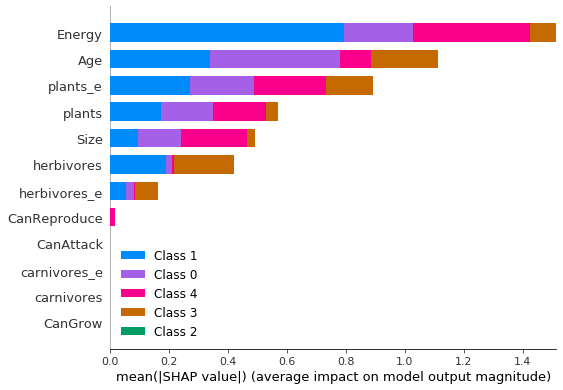

In [29]:
shap.summary_plot(shap_values, features=X_test, plot_type="bar")

As we can see the most important Feature is Energy and the second one is Age.

#### Activity Zero

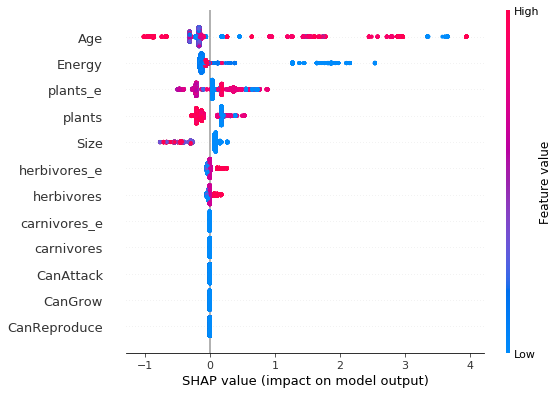

In [30]:
shap.summary_plot(shap_values[0], features=X_test)

## Simplified plot

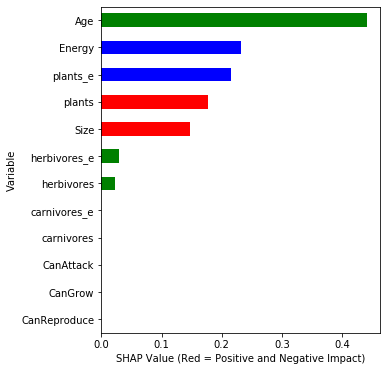

In [35]:
ABS_SHAP(shap_values[0],X_test)

Age, Herbovores and herbovores_e are possitively correlated and size and Plants are negative correlated.

#### Activity One

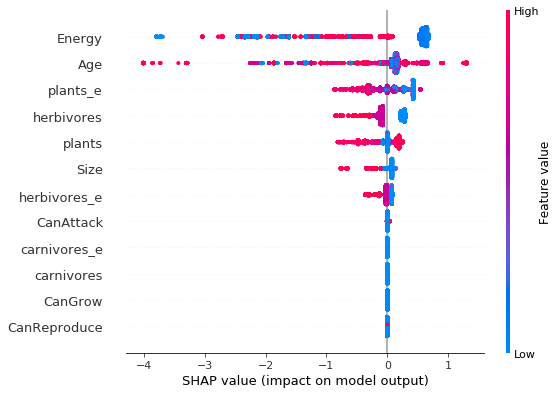

In [32]:
shap.summary_plot(shap_values[1], features=X_test)

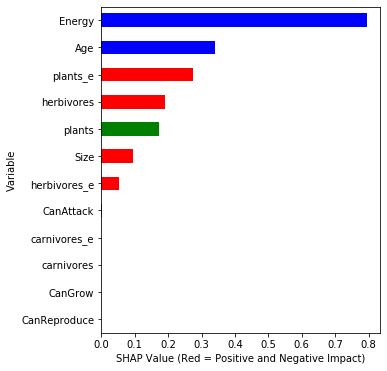

In [36]:
ABS_SHAP(shap_values[1],X_test)

Here herbovores, herbovores_e, Size and plants_e are negative correlated and plants is possitive correlated.

For Activity 2 Plants is possitively correlated and age, plants_e ,herbovores, herbovores_e, CanGrow and CanReproduce are negative correlated.

#### Activity Four

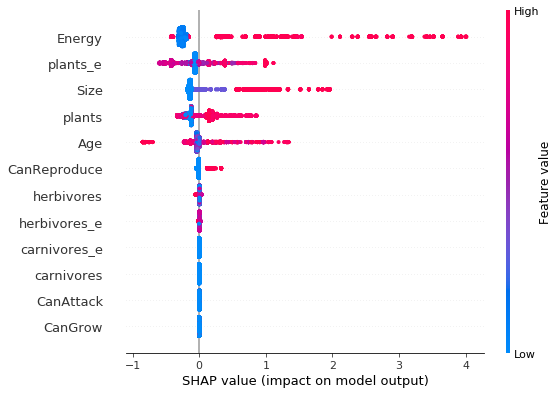

In [37]:
shap.summary_plot(shap_values[4], features=X_test)

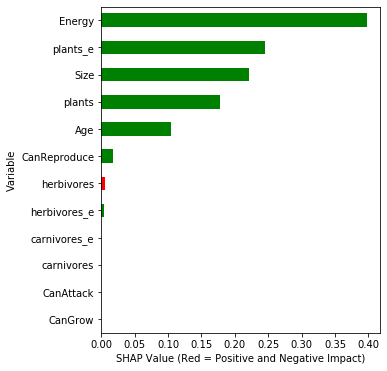

In [38]:
ABS_SHAP(shap_values[4],X_test)

As we can see activity 4 is positively correlated with Age, Size, plants_e, herbovores_e,  and Energy.

### Explaining  single prediction

In [42]:
print(f'True value : {y_test.iloc[0]}')
max_ = np.argmax(y_pred[0])
print("Our prediction: ",max_)
print(f'Probability : {round(y_pred[0][max_],4)}')
print(f'Raw model prediction (logit) : {gbm.predict(X_test, raw_score=True)[0]}')

True value : 1
Our prediction:  1
Probability : 0.9994
Raw model prediction (logit) : [ -6.30400354   2.02151045 -34.53877639  -6.96699254  -6.28998012]


In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value[max_], shap_values[max_][0,:], features=X_test.iloc[0, :])

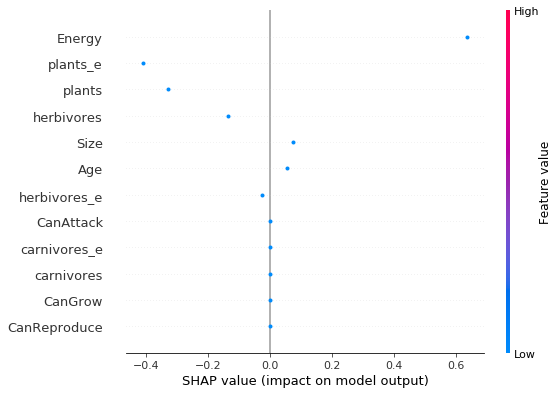

In [44]:
shap.summary_plot(shap_values[max_][0:1,:], features=X_test.iloc[0:1,:])

Energy, Size and Age has possitive Sharp Values which Pushing the Prediction higher and Plants_e, Plants and Herbiores pushing prediction lower.

Let's Check another Example.

In [52]:
print(f'True value : {y_test.iloc[14]}')
max_ = np.argmax(y_pred[14])
print("Our prediction: ",max_)
print(f'Probability : {round(y_pred[14][max_],4)}')
print(f'Raw model prediction (logit) : {gbm.predict(X_test, raw_score=True)[14]}')

True value : 0
Our prediction:  0
Probability : 0.9807
Raw model prediction (logit) : [ -0.12610623  -4.20909842 -34.53877639  -7.03776623  -6.4116232 ]


In [53]:
shap.force_plot(explainer.expected_value[max_], shap_values[max_][14,:], features=X_test.iloc[14, :])

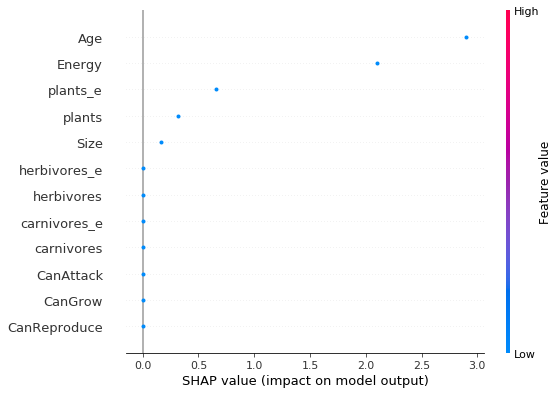

In [54]:
shap.summary_plot(shap_values[max_][14:15,:], features=X_test.iloc[14:15,:])

Energy and age has higher SHAP Values which are pushing the Prediction to Activity 0.

In [56]:
print(f'True value : {y_test.iloc[8]}')
max_ = np.argmax(y_pred[8])
print("Our prediction: ",max_)
print(f'Probability : {round(y_pred[8][max_],4)}')
print(f'Raw model prediction (logit) : {gbm.predict(X_test, raw_score=True)[8]}')

True value : 4
Our prediction:  4
Probability : 0.9633
Raw model prediction (logit) : [ -7.76562259  -2.93751469 -34.53877639  -6.73804105   0.36085464]


In [57]:
shap.force_plot(explainer.expected_value[max_], shap_values[max_][8,:], features=X_test.iloc[8, :])

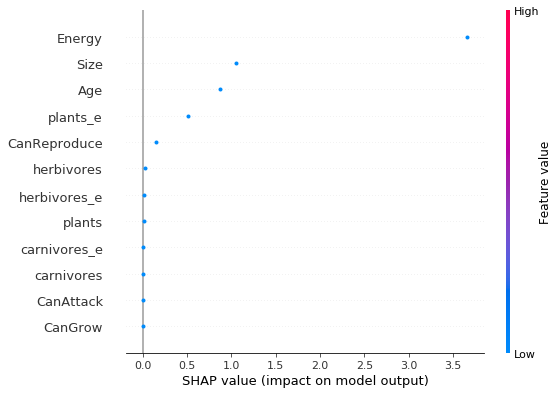

In [58]:
shap.summary_plot(shap_values[max_][8:9,:], features=X_test.iloc[8:9,:])

Energy has highest Value which is pushing the Activity to 4.